In [1]:
# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import division


import os, sys
from os.path import join, exists, abspath, isfile, isdir, basename, abspath, splitext
import shutil


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
#from scipy.misc import 
from imageio import imread
from collections import OrderedDict
import warnings
from IPython.core.display import display, HTML, SVG

%matplotlib inline

In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
# https://normalized2.github.io/apollo/#/doc?image=7103
# !wget https://c1.staticflickr.com/1/593/21469409550_621bf02a03_o.jpg -O AS12-48-7103.jpg

# https://normalized2.github.io/apollo/#/doc?image=7104
# !wget https://c1.staticflickr.com/1/588/21666478171_9564de18fc_o.jpg -O AS12-48-7104.jpg

# utils

In [4]:
def load_labels(fn_labels='a.json'):
    with open(fn_labels) as f:
        labels = json.load(f)
    rows = []
    for label in labels:
        for annotation in label['annotations']:

            row = {}
            #row['filename'] = basename(label['filename'])
            row['fileid'] = splitext(basename(label['filename']))[0]
            for key in annotation.keys():
                row[key] = annotation[key]

            if row['class'].startswith('rock'):
                row['cx'] = row['x'] + row['width'] / 2
                row['cy'] = row['y'] + row['height'] / 2

            rows.append(row)
    df_label = pd.DataFrame(rows)
    df_label = df_order_columns(df_label, ['fileid', 'class', 'x', 'y', 'cx', 'cy'])
    return df_label


def df_order_columns(df, columns_ordered=[]):
    """
    Order some columns, and remain other as was
    """
    columns = []
    for c in columns_ordered:
        if c in df.columns:
            columns.append(c)
    remains = [c for c in df.columns if c not in columns]
    columns = columns + remains

    assert len(columns) == len(df.columns)
    return df[columns]

def draw_image_with_labels(img, fileid, labels=None, ax=None, linewidth=3):
    if ax is None:
        ax = plt.gca()
    if labels is None:
        labels = df_labels

    ax.set_axis_off()
    ax.imshow(img)
    
    labels = labels[labels.fileid == fileid]
    for i, row in labels.iterrows():
        if row['class'].startswith('rock'):
           
            # Create a Rectangle patch
            rect = patches.Rectangle((row['x'], row['y']),row['width'], row['height'], linewidth=linewidth, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
            
            ax.text(row['x'], row['y'] - 30, row['class'], color='red', fontsize=14)


In [5]:
df_labels = load_labels()
df_labels

,fileid,class,x,y,cx,cy,height,width
0,AS12-48-7103,rock1,2483.893600,1211.349586,2500.665803,1225.442524,28.185875,33.544406
1,AS12-48-7103,rock2,1329.808447,1190.676922,1336.492798,1197.576897,13.799950,13.368701
2,AS12-48-7103,rock3,2008.627841,1998.413460,2028.005121,2019.292855,41.758790,38.754560
3,AS12-48-7103,cross1,3582.900000,1360.850000,NaN,NaN,NaN,NaN
4,AS12-48-7103,cross2,570.562137,1384.429544,NaN,NaN,NaN,NaN
5,AS12-48-7103,cross3,1336.579508,2883.281436,NaN,NaN,NaN,NaN
6,AS12-48-7104,rock1,3952.230165,1074.132033,3970.450411,1089.495258,30.726451,36.440493
7,AS12-48-7104,rock2,2714.206997,1090.628715,2720.615027,1097.262380,13.267330,12.816061
8,AS12-48-7104,rock3,3423.259141,1911.246651,3443.734625,1930.815471,39.137641,40.950968
9,AS12-48-7104,cross3,1336.850000,2899.100000,NaN,NaN,NaN,NaN


In [6]:
fileid_1 = 'AS12-48-7103'
fileid_2 = 'AS12-48-7104'

img1 = imread('{}.jpg'.format(fileid_1))
img2 = imread('{}.jpg'.format(fileid_2))

img1.shape, img2.shape

((4175, 4175, 3), (4175, 4175, 3))

In [7]:
#fig, axes = plt.subplots(ncols=1, figsize=(16, 16))
#draw_image_with_labels(img1, fileid=fileid_1)

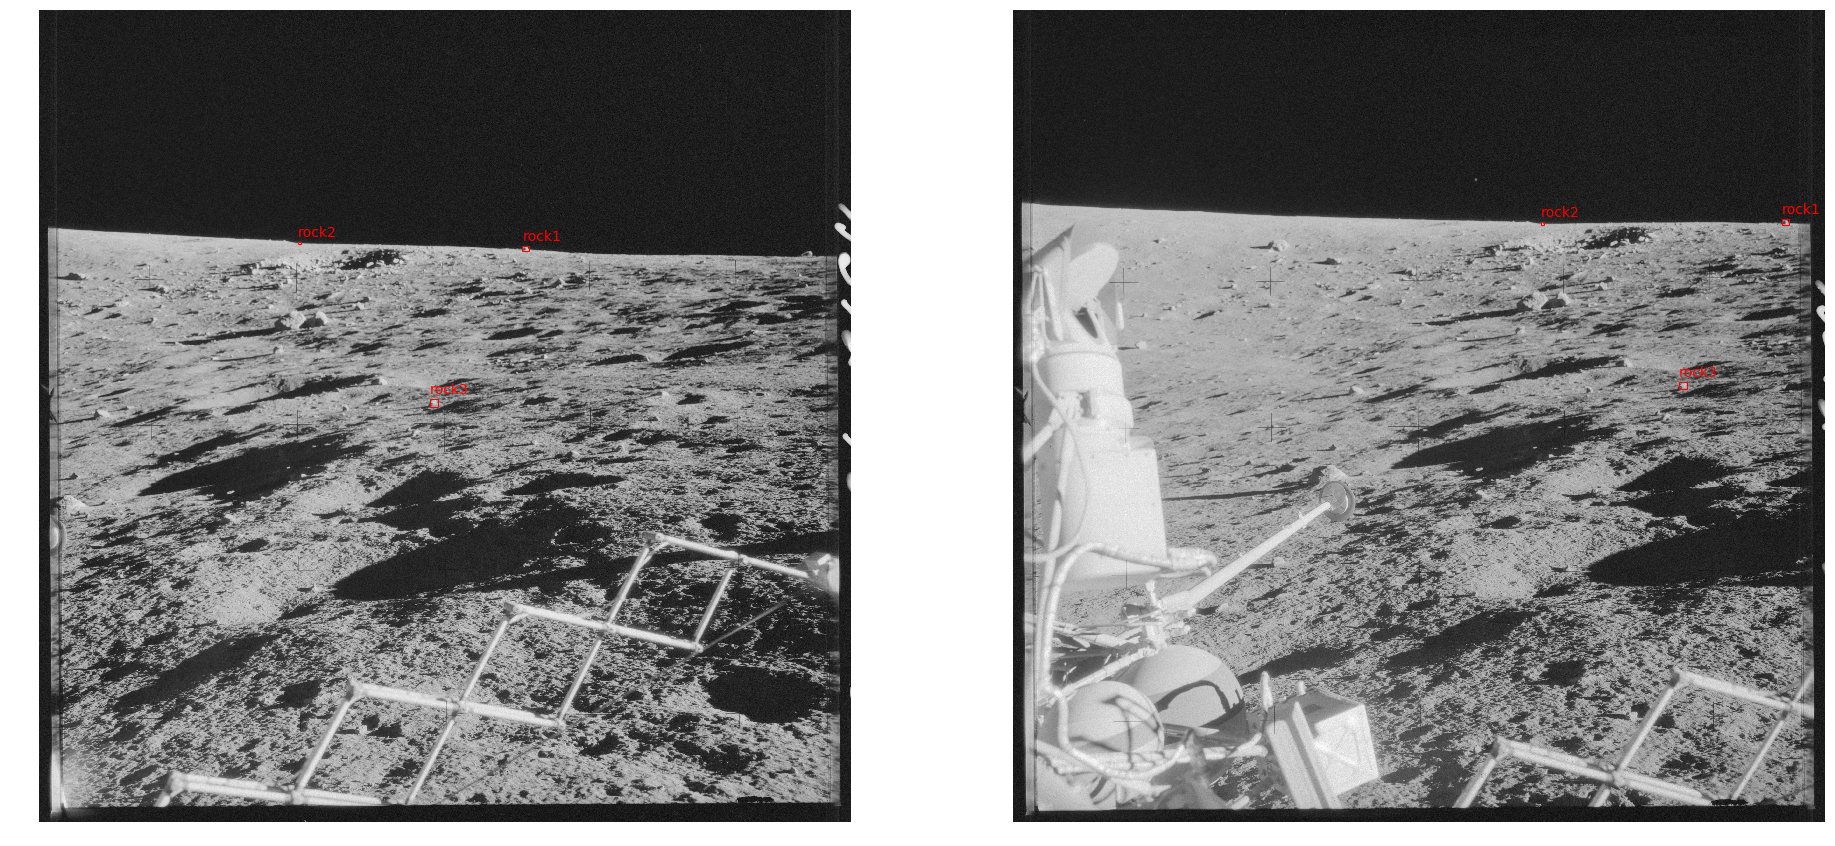

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(32, 16))
draw_image_with_labels(img1, fileid=fileid_1, ax=axes[0], linewidth=1)


ax = axes[1]
draw_image_with_labels(img2, fileid=fileid_2, ax=axes[1], linewidth=1)


## Вычисление матрицы преобразований (без масштабирования)

https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%BF%D0%B5%D1%80%D0%B5%D1%85%D0%BE%D0%B4%D0%B0

https://math.stackexchange.com/questions/237369/given-this-transformation-matrix-how-do-i-decompose-it-into-translation-rotati

In [9]:
df_labels

,fileid,class,x,y,cx,cy,height,width
0,AS12-48-7103,rock1,2483.893600,1211.349586,2500.665803,1225.442524,28.185875,33.544406
1,AS12-48-7103,rock2,1329.808447,1190.676922,1336.492798,1197.576897,13.799950,13.368701
2,AS12-48-7103,rock3,2008.627841,1998.413460,2028.005121,2019.292855,41.758790,38.754560
3,AS12-48-7103,cross1,3582.900000,1360.850000,NaN,NaN,NaN,NaN
4,AS12-48-7103,cross2,570.562137,1384.429544,NaN,NaN,NaN,NaN
5,AS12-48-7103,cross3,1336.579508,2883.281436,NaN,NaN,NaN,NaN
6,AS12-48-7104,rock1,3952.230165,1074.132033,3970.450411,1089.495258,30.726451,36.440493
7,AS12-48-7104,rock2,2714.206997,1090.628715,2720.615027,1097.262380,13.267330,12.816061
8,AS12-48-7104,rock3,3423.259141,1911.246651,3443.734625,1930.815471,39.137641,40.950968
9,AS12-48-7104,cross3,1336.850000,2899.100000,NaN,NaN,NaN,NaN


In [10]:
p1_fig1 = df_labels[(df_labels.fileid==fileid_1) & (df_labels['class']=='rock1')][['cx', 'cy']].values
p2_fig1 = df_labels[(df_labels.fileid==fileid_1) & (df_labels['class']=='rock2')][['cx', 'cy']].values


p1_fig2 = df_labels[(df_labels.fileid==fileid_2) & (df_labels['class']=='rock1')][['cx', 'cy']].values
p2_fig2 = df_labels[(df_labels.fileid==fileid_2) & (df_labels['class']=='rock2')][['cx', 'cy']].values


In [11]:
p1_fig1, p2_fig1, p1_fig1 - p2_fig1

(array([[2500.66580315, 1225.44252367]]),
 array([[1336.49279809, 1197.5768968 ]]),
 array([[1164.17300506,   27.86562687]]))

In [12]:
p1_fig2, p2_fig2, p1_fig2 - p2_fig2

(array([[3970.45041114, 1089.49525843]]),
 array([[2720.61502713, 1097.26238032]]),
 array([[1249.83538401,   -7.76712189]]))

In [13]:
l1 = np.linalg.norm(p1_fig1 - p2_fig1)
l2 = np.linalg.norm(p1_fig2 - p2_fig2)
l1 , l2

(1164.506452911272, 1249.8595182285162)

In [14]:
np.abs(l1 - l2) / l1

0.07329548505623235

In [15]:
p1_fig1 = df_labels[(df_labels.fileid==fileid_1) & (df_labels['class']=='cross1')][['x', 'y']].values
p2_fig1 = df_labels[(df_labels.fileid==fileid_1) & (df_labels['class']=='cross2')][['x', 'y']].values


p1_fig2 = df_labels[(df_labels.fileid==fileid_2) & (df_labels['class']=='cross1')][['x', 'y']].values
p2_fig2 = df_labels[(df_labels.fileid==fileid_2) & (df_labels['class']=='cross2')][['x', 'y']].values



In [16]:
p1_fig1, p2_fig1, p1_fig1 - p2_fig1

(array([[3582.9 , 1360.85]]),
 array([[ 570.56213728, 1384.42954393]]),
 array([[3012.33786272,  -23.57954393]]))

In [17]:
p1_fig2, p2_fig2, p1_fig2 - p2_fig2

(array([[3583.053225, 1376.95806 ]]),
 array([[ 570.485295, 1400.318235]]),
 array([[3012.56793 ,  -23.360175]]))

In [18]:
l1 = np.linalg.norm(p1_fig1 - p2_fig1)
l2 = np.linalg.norm(p1_fig2 - p2_fig2)
l1 , l2

(3012.4301475810607, 3012.6584988412724)

In [19]:
np.abs(l1 - l2) / l1

7.580300588712463e-05

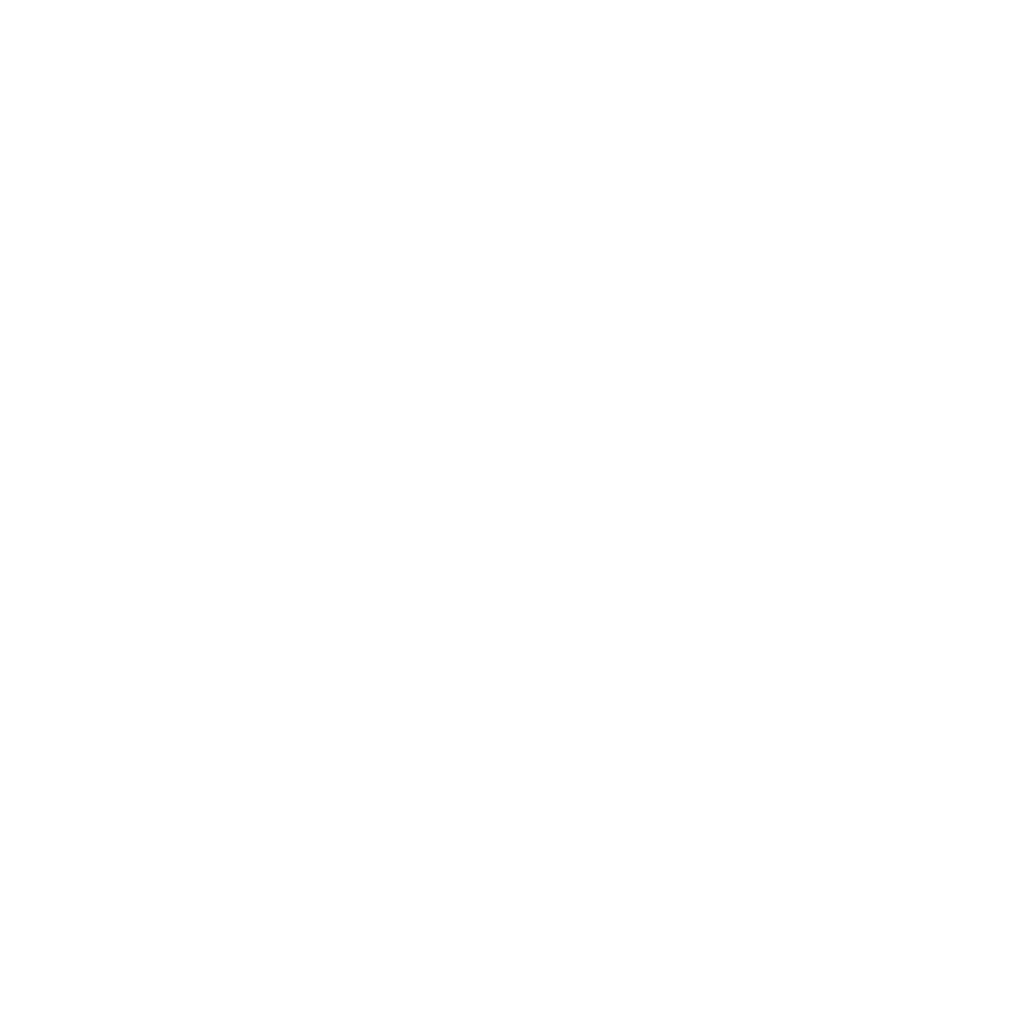

In [20]:
svg = """<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns="http://www.w3.org/2000/svg"
   xmlns:xlink="http://www.w3.org/1999/xlink"
   version="1.1"
   id="svg2"
   viewBox="0 0 1024 1024"
   height="1024"
   width="1024"
   style="background-color: white;"
   >

   <style>
    /* <![CDATA[ */
    circle {
      fill: none;
      stroke: blue;
      stroke-width: 2px;
    }
    
    line {
     fill: red;
     stroke: red;
     stroke-width: 2px;
    }
    /* ]]> */
  </style>
  
  <defs>
    <marker id="arrow" viewBox="0 0 10 10" refX="5" refY="5"
        markerWidth="6" markerHeight="6"
        orient="auto-start-reverse">
      <path d="M 0 0 L 10 5 L 0 10 z" fill="red"/>
    </marker>
  </defs>

  <g>
  
      <image xlink:href="AS12-48-7103.jpg" x="0" y="0" height="1024" width="1024" opacity="0.5"/>
      
      
      <g transform="translate(-358, 13)  rotate(1.3)">
          <image xlink:href="AS12-48-7104.jpg" x="0" y="0" height="1024" width="1024" opacity="0.5"/>
      </g>
      
  </g>
</svg>

"""
SVG(svg)